In [2]:
using LogicCircuits
using ProbabilisticCircuits
using DataFrames
using BenchmarkTools
using TikzPictures
using Statistics: mean
using LinearAlgebra: normalize
using Clustering: kmeans, nclusters, assignments
TikzPictures.standaloneWorkaround(true)

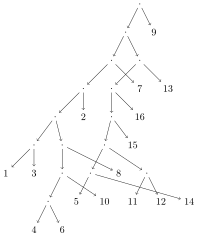

In [5]:
train_x, valid_x, test_x = twenty_datasets("nltcs")
pc_cl, vtree_cl = learn_chow_liu_tree_circuit(train_x)
plot(vtree_cl)

In [87]:
nd = 1000
d = train_x[1:nd,:] # Using fewer data for quicker tests
vtree = vtree_cl

function bs2arr(bs)
    y = variables(bs) # parsing the indexes of the variables on the right DEBUG: case of a single var
    yy = (x->collect.(x)).(y)
    b = zeros(Int8,size(yy,1))
    for i = 1:size(yy,1)
        b[i] = yy[i][1]
    end
    return b
end

function lr(vtree)
    if typeof(vtree.left) == PlainVtreeLeafNode && typeof(vtree.right) == PlainVtreeLeafNode
        l = [variable(vtree.left)+1-1]
        r = [variable(vtree.right)+1-1] 
    elseif typeof(vtree.left) == PlainVtreeLeafNode
        l = [variable(vtree.left)+1-1]
        r = bs2arr(vtree.right)
    else
        l = bs2arr(vtree.left)
        r = bs2arr(vtree.right)
    end    
    return [l,r]
end

const NCLUSTERS = 3
DB_TITLE = names(d)
const MINCLUSTERSIZE = 20

function find_names(names_short,indexes_short)
    m=Any[]
    for i in indexes_short
        push!(m,findfirst(x->x==DB_TITLE[i], names_short))
    end
    return m
end

function clustering2(data, mix_num::Int64; maxiter=200)::Vector
    n = num_examples(data)
    if mix_num == 1
        return [data]
    end
    data = Matrix(data)
    R = kmeans(data', mix_num; maxiter=maxiter)
    @assert nclusters(R) == mix_num
    a = assignments(R)

    clustered_data = Vector()
    for k in 1 : mix_num
        push!(clustered_data, DataFrame(data[findall(x -> x == k, a), :]))
    end

    return [clustered_data,a]
end


function LearnDecision(d,v)
    if typeof(v) == PlainVtreeLeafNode # Leaf, nothing to do, just write L ...
        println("L ",variable(v))
    else
        variables = lr(v) # Let's find right and left variables
        for i = 1:2
            variables[i] = find_names(names(d),variables[i])
        end
        if size(variables[1],1) == 1 
            if size(variables[2],1) > 1 # CASE 1: Single var on the left, many on the right
                dd = [filter(row -> row[variables[1][1]] == i, d) for i in 0:1]
                p = [size(dd[i],1)/size(d,1) for i in 1:2]
                println("D X X ",p[1]," ",p[2]," # Shannon su X",variables[1][1]," dx = ",variables[2])
                for c in 1:2
                    LearnDecision(dd[c],v.right)
                end            
            else
                println("L X X Ultima # X",variables[1][1]," X",variables[2][1])
            end
        else
            if size(d,1) > MINCLUSTERSIZE
                d_left = d[:,variables[1]]
                d_right = d[:,variables[2]]
                clsts2 = clustering2(d_left,NCLUSTERS)
                clsts = clsts2[1]
                assignments = clsts2[2]
                p = [size(clsts[c],1)/size(d,1) for c = 1:NCLUSTERS]
                println("D ",p," # X",variables[1]," X",variables[2])
                for c = 1:NCLUSTERS
                    rename!(clsts[c],names(d_left))
                    LearnDecision(clsts[c],v.left)
                    d2 = d_right[findall(x->x==c, assignments),:]
                    LearnDecision(d2,v.right)
                end
            end
        end
    end
end

#file = zoo_psdd_file("little_4var.psdd")
#print(file)
#prob_circuit = load_prob_circuit(file);
LearnDecision(d,vtree)
println("Finito")

D X X 0.813 0.187 # Shannon su X9 dx = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
D 0.3972939729397294 0.22263222632226323 0.3800738007380074 # XInt8[1, 2, 3, 4, 6, 7, 8, 10] XInt8[5, 11, 12, 13, 14, 15, 16]
D X X 0.978328173374613 0.021671826625386997 # Shannon su X6 dx = [1, 2, 3, 4, 5, 7, 8]
D X X 0.930379746835443 0.06962025316455696 # Shannon su X2 dx = [1, 3, 4, 5, 7, 8]
D 0.9149659863945578 0.047619047619047616 0.03741496598639456 # XInt8[1, 3] XInt8[4, 5, 7, 8]
L X X Ultima # X2 X1
D X X 0.9219330855018587 0.07806691449814127 # Shannon su X3 dx = [1, 2, 4]
D 0.4596774193548387 0.45161290322580644 0.08870967741935484 # XInt8[1, 2] XInt8[4]
L X X Ultima # X2 X1
L 10
L X X Ultima # X2 X1
L 10
L X X Ultima # X2 X1
L 10
D 0.42857142857142855 0.23809523809523808 0.3333333333333333 # XInt8[1, 2] XInt8[4]
L X X Ultima # X2 X1
L 10
L X X Ultima # X2 X1
L 10
L X X Ultima # X2 X1
L 10
L X X Ultima # X2 X1
D X X 0.9285714285714286 0.07142857142857142 # Shannon su X3 dx = [1, 2, 4